In [16]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook

In [17]:
data = pd.read_csv("international-airline-passengers.csv")
data.head()

,Month,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [18]:
data.columns = ["dt", "Passengers"]

In [19]:
data.head()

,dt,Passengers
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [20]:
data.shape

(145, 2)

In [21]:
data = data.iloc[:-1]

In [22]:
data["dt"] = data["dt"].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m'))

<IPython.core.display.Javascript object>


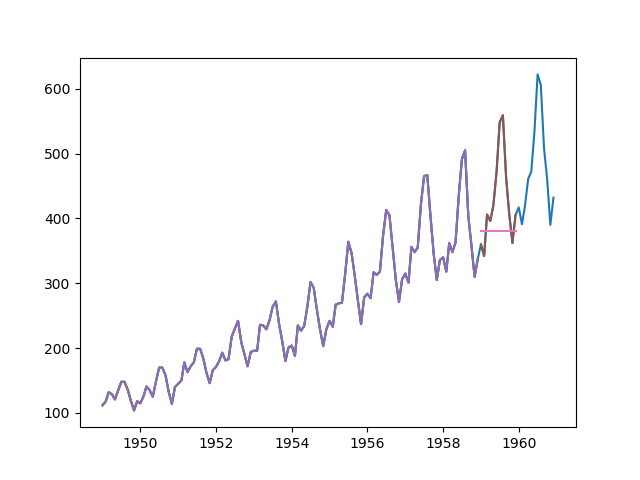

In [24]:
plt.plot(data["dt"], data["Passengers"])

In [25]:
plt.plot(data["dt"].iloc[:12], data["Passengers"].iloc[:12])

In [26]:
data[["dt"]].groupby(data["dt"].dt.year).count()

,dt
dt,
1949,12
1950,12
1951,12
1952,12
1953,12
1954,12
1955,12
1956,12
1957,12


In [54]:
def create_xy(df, target_column):
    return df.drop(target_column, axis=1), df[target_column]

def split_data(df, target_column):
    X_train, y_train = create_xy(df.query("dt < 1959"), target_column)
    X_dev, y_dev = create_xy(df.query("dt >= 1959 and dt < 1960"), target_column)
    X_test, y_test = create_xy(df.query("dt >= 1960"), target_column)
    return X_train, y_train, X_dev, y_dev, X_test, y_test

In [55]:
X_train, y_train, X_dev, y_dev, X_test, y_test = split_data(data, "Passengers")

In [56]:
X_train[["dt"]].groupby(X_train["dt"].dt.year).count()

,dt
dt,
1949,12
1950,12
1951,12
1952,12
1953,12
1954,12
1955,12
1956,12
1957,12


In [57]:
y_dev_hat = [y_train[X_train["dt"].dt.year == 1958].mean()]*12

In [58]:
data.query("dt >= 1959 and dt < 1960")

,dt,Passengers
120,1959-01-01,360.0
121,1959-02-01,342.0
122,1959-03-01,406.0
123,1959-04-01,396.0
124,1959-05-01,420.0
125,1959-06-01,472.0
126,1959-07-01,548.0
127,1959-08-01,559.0
128,1959-09-01,463.0
129,1959-10-01,407.0


<IPython.core.display.Javascript object>


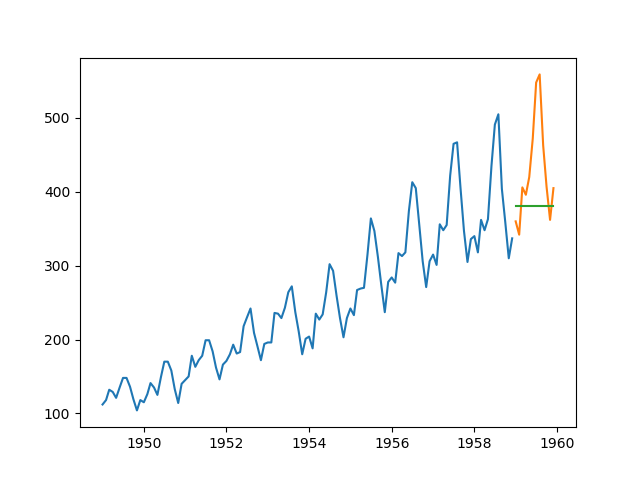

In [62]:
figure = plt.subplots(1,1)
plt.plot(X_train, y_train)
plt.plot(X_dev, y_dev)
plt.plot(X_dev, y_dev_hat)

In [65]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(y_dev, y_dev_hat))

81.91662427940578

In [66]:
from pandas import Series
from statsmodels.tsa.seasonal import seasonal_decompose

<IPython.core.display.Javascript object>


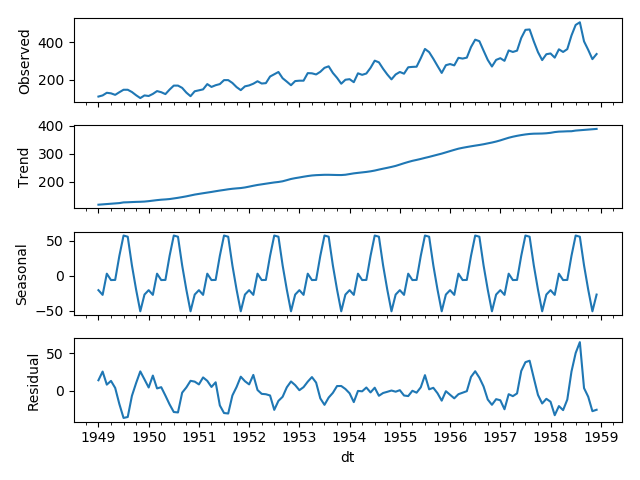

In [77]:
train = pd.DataFrame()
train["dt"] = X_train["dt"]
train["y"] = y_train
series = train.set_index("dt")
result = seasonal_decompose(series, model="additive", extrapolate_trend="freq")
result.plot()
plt.show()

In [79]:
result.trend

,y
dt,
1949-01-01,118.588481
1949-02-01,119.734169
1949-03-01,120.879856
1949-04-01,122.025544
1949-05-01,123.171232
1949-06-01,124.316919
1949-07-01,126.791667
1949-08-01,127.250000
1949-09-01,127.958333


In [81]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(result.trend.index, result.trend["y"])

#y_dev_hat = reg.predict(validation[["sales-1", "sales-11", "sales-12"]])

ValueError: Expected 2D array, got 1D array instead:
array=['1949-01-01T00:00:00.000000000' '1949-02-01T00:00:00.000000000'
 '1949-03-01T00:00:00.000000000' '1949-04-01T00:00:00.000000000'
 '1949-05-01T00:00:00.000000000' '1949-06-01T00:00:00.000000000'
 '1949-07-01T00:00:00.000000000' '1949-08-01T00:00:00.000000000'
 '1949-09-01T00:00:00.000000000' '1949-10-01T00:00:00.000000000'
 '1949-11-01T00:00:00.000000000' '1949-12-01T00:00:00.000000000'
 '1950-01-01T00:00:00.000000000' '1950-02-01T00:00:00.000000000'
 '1950-03-01T00:00:00.000000000' '1950-04-01T00:00:00.000000000'
 '1950-05-01T00:00:00.000000000' '1950-06-01T00:00:00.000000000'
 '1950-07-01T00:00:00.000000000' '1950-08-01T00:00:00.000000000'
 '1950-09-01T00:00:00.000000000' '1950-10-01T00:00:00.000000000'
 '1950-11-01T00:00:00.000000000' '1950-12-01T00:00:00.000000000'
 '1951-01-01T00:00:00.000000000' '1951-02-01T00:00:00.000000000'
 '1951-03-01T00:00:00.000000000' '1951-04-01T00:00:00.000000000'
 '1951-05-01T00:00:00.000000000' '1951-06-01T00:00:00.000000000'
 '1951-07-01T00:00:00.000000000' '1951-08-01T00:00:00.000000000'
 '1951-09-01T00:00:00.000000000' '1951-10-01T00:00:00.000000000'
 '1951-11-01T00:00:00.000000000' '1951-12-01T00:00:00.000000000'
 '1952-01-01T00:00:00.000000000' '1952-02-01T00:00:00.000000000'
 '1952-03-01T00:00:00.000000000' '1952-04-01T00:00:00.000000000'
 '1952-05-01T00:00:00.000000000' '1952-06-01T00:00:00.000000000'
 '1952-07-01T00:00:00.000000000' '1952-08-01T00:00:00.000000000'
 '1952-09-01T00:00:00.000000000' '1952-10-01T00:00:00.000000000'
 '1952-11-01T00:00:00.000000000' '1952-12-01T00:00:00.000000000'
 '1953-01-01T00:00:00.000000000' '1953-02-01T00:00:00.000000000'
 '1953-03-01T00:00:00.000000000' '1953-04-01T00:00:00.000000000'
 '1953-05-01T00:00:00.000000000' '1953-06-01T00:00:00.000000000'
 '1953-07-01T00:00:00.000000000' '1953-08-01T00:00:00.000000000'
 '1953-09-01T00:00:00.000000000' '1953-10-01T00:00:00.000000000'
 '1953-11-01T00:00:00.000000000' '1953-12-01T00:00:00.000000000'
 '1954-01-01T00:00:00.000000000' '1954-02-01T00:00:00.000000000'
 '1954-03-01T00:00:00.000000000' '1954-04-01T00:00:00.000000000'
 '1954-05-01T00:00:00.000000000' '1954-06-01T00:00:00.000000000'
 '1954-07-01T00:00:00.000000000' '1954-08-01T00:00:00.000000000'
 '1954-09-01T00:00:00.000000000' '1954-10-01T00:00:00.000000000'
 '1954-11-01T00:00:00.000000000' '1954-12-01T00:00:00.000000000'
 '1955-01-01T00:00:00.000000000' '1955-02-01T00:00:00.000000000'
 '1955-03-01T00:00:00.000000000' '1955-04-01T00:00:00.000000000'
 '1955-05-01T00:00:00.000000000' '1955-06-01T00:00:00.000000000'
 '1955-07-01T00:00:00.000000000' '1955-08-01T00:00:00.000000000'
 '1955-09-01T00:00:00.000000000' '1955-10-01T00:00:00.000000000'
 '1955-11-01T00:00:00.000000000' '1955-12-01T00:00:00.000000000'
 '1956-01-01T00:00:00.000000000' '1956-02-01T00:00:00.000000000'
 '1956-03-01T00:00:00.000000000' '1956-04-01T00:00:00.000000000'
 '1956-05-01T00:00:00.000000000' '1956-06-01T00:00:00.000000000'
 '1956-07-01T00:00:00.000000000' '1956-08-01T00:00:00.000000000'
 '1956-09-01T00:00:00.000000000' '1956-10-01T00:00:00.000000000'
 '1956-11-01T00:00:00.000000000' '1956-12-01T00:00:00.000000000'
 '1957-01-01T00:00:00.000000000' '1957-02-01T00:00:00.000000000'
 '1957-03-01T00:00:00.000000000' '1957-04-01T00:00:00.000000000'
 '1957-05-01T00:00:00.000000000' '1957-06-01T00:00:00.000000000'
 '1957-07-01T00:00:00.000000000' '1957-08-01T00:00:00.000000000'
 '1957-09-01T00:00:00.000000000' '1957-10-01T00:00:00.000000000'
 '1957-11-01T00:00:00.000000000' '1957-12-01T00:00:00.000000000'
 '1958-01-01T00:00:00.000000000' '1958-02-01T00:00:00.000000000'
 '1958-03-01T00:00:00.000000000' '1958-04-01T00:00:00.000000000'
 '1958-05-01T00:00:00.000000000' '1958-06-01T00:00:00.000000000'
 '1958-07-01T00:00:00.000000000' '1958-08-01T00:00:00.000000000'
 '1958-09-01T00:00:00.000000000' '1958-10-01T00:00:00.000000000'
 '1958-11-01T00:00:00.000000000' '1958-12-01T00:00:00.000000000'].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.